In [2]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Problem 1

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [107]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# determine the properties
rows,cols = x_train[0].shape
num_classes = 10

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# use a built-in function to get 1-hot encoding
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

In [104]:
def plot_digit_array(x,y, show_prediction=False):
    '''Expects a list of digits (x) and associated labels (y)'''
    
    # determine the number of rows and columns of our image array
    num_digits = x.shape[0]
    num_cols = int(np.sqrt(num_digits))
    num_rows = num_digits//num_cols + 1

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    
    # plot all the numbers
    for i,cax in enumerate(ax.flatten()):
        if i < num_digits:
            cax.matshow(x[i].reshape(28,28), cmap='binary')
            cax.axis('off')
            if show_prediction:
                cax.text(0.99,0.99,f'{y[i]}',horizontalalignment='right',verticalalignment='top', 
                         transform=cax.transAxes, fontsize=8, color='r')
        else:
            cax.axis('off')

In [108]:
# instantiate model
model = keras.Sequential(
[
    layers.Conv2D(input_shape=(rows,cols, 1), kernel_size=(5, 5), filters=7,
                  activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(4, 4)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])



# compile 
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 7)         182       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 343)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                3440      
Total params: 3,622
Trainable params: 3,622
Non-trainable params: 0
_________________________________________________________________


In [109]:
batch_size = 64
epochs = 10

training = model.fit(x_train,y_train_hot, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test_hot))

Epoch 1/10
938/938 [==============================] - 13s 13ms/step - loss: 0.8856 - accuracy: 0.7477 - val_loss: 0.2340 - val_accuracy: 0.9315
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 0.2269 - accuracy: 0.9325 - val_loss: 0.1546 - val_accuracy: 0.9548
Epoch 3/10
938/938 [==============================] - 12s 13ms/step - loss: 0.1531 - accuracy: 0.9550 - val_loss: 0.1119 - val_accuracy: 0.9671
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.1157 - accuracy: 0.9662 - val_loss: 0.0968 - val_accuracy: 0.9699
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.1041 - accuracy: 0.9694 - val_loss: 0.0817 - val_accuracy: 0.9748
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0887 - accuracy: 0.9733 - val_loss: 0.0796 - val_accuracy: 0.9754
Epoch 7/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0826 - accuracy: 0.9743 - val_loss: 0.0726 - val_accuracy:

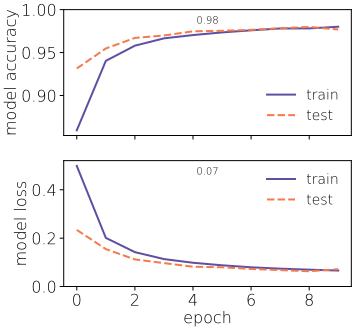

In [110]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, figsize=(5,5))

score = model.evaluate(x_test, y_test_hot, verbose=0);

# accuracy
ax[0].plot(training.history['accuracy'], color=colors[0])
ax[0].plot(training.history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].text(0.5,0.95,f'{score[1]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[0].transAxes)
ax[0].set_ylim(top=1)

# loss
ax[1].plot(training.history['loss'], color=colors[0])
ax[1].plot(training.history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylim(bottom=0)
ax[1].text(0.5,0.95,f'{score[0]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[1].transAxes)
ax[1].legend(['train', 'test'], loc='best');

In [111]:
predictions_prob_train = model(x_train)
predictions_prob_test = model(x_test)

predictions_train = np.argmax(predictions_prob_train,axis=1)
predictions_test = np.argmax(predictions_prob_test,axis=1)

mistakes_train = np.where(predictions_train != y_train)[0]
mistakes_test = np.where(predictions_test != y_test)[0]

num_mistakes_train,num_mistakes_test = len(mistakes_train),len(mistakes_test)

print(f'Train Mistakes: {100*num_mistakes_train/x_train.shape[0]:.2f}%')
print(f'Test Mistakes : {100*num_mistakes_test/x_test.shape[0]:.2f}%')

Train Mistakes: 2.10%
Test Mistakes : 2.31%


Now I will import hand drawn images and preprocess them. The raw images are 140x140 RGBA images that will be converted to 28x28, centered, normalized 8 bit images.

In [112]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from PIL import ImageEnhance
from PIL import ImageOps
import matplotlib.patches as patches


In [113]:
input_folder = 'myMNIST/'

digits_raw = []
labels = []

# Import raw images in grayscale mode

for i in range(10):
    filename = input_folder + str(i) + '.png'
    image = Image.open(filename)
    image = image.convert(mode = 'L')
    digits_raw.append(image)
    labels.append(i)

labels = np.array(labels)

In [114]:
digits_centered = [] # Center the images

for digit in digits_raw:

    # Inver sample, get bbox and display all that stuff.
    inv_sample = ImageOps.invert(digit)
    bbox = inv_sample.getbbox()
    rect = patches.Rectangle(
        (bbox[0], bbox[3]), bbox[2]-bbox[0], -bbox[3]+bbox[1]-1,
        fill=False, alpha=1, edgecolor='w')

    crop = inv_sample.crop(bbox)

    new_size = 140
    delta_w = new_size - crop.size[0]
    delta_h = new_size - crop.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(crop, padding)
    
    digits_centered.append(new_im)

In [115]:
def normalize(img_in):
    img = np.asarray(img_in)
    
    # normalize
    max_val = float(img.max())
    #print(max_val)

    x_dim, y_dim = img.shape

    norm_img = np.zeros_like(img)

    for i in range(x_dim):
        for j in range(y_dim):
            norm_img[i, j] = img[i, j] / max_val
    
    return norm_img

def downscale(img_source, x0_raw, x1_raw):
    x_dim, y_dim = img_source.shape
    x0 = np.floor(x0_raw * x_dim*0.9999).astype(int)
    x1 = np.floor(x1_raw * y_dim*0.9999).astype(int)
    return img_source[x0, x1]

In [119]:
digits_norm = [] # normalize each pixel value in [0,1] range

for digit in digits_centered:
    digits_norm.append(normalize(digit))

In [123]:
my_digits = [] # Final dataset to make images 28x28

grid_size = 28
extent = [0, 1, 0, 1]

X = np.meshgrid(np.linspace(extent[0],extent[1],grid_size,dtype=float),
                np.linspace(extent[2],extent[3],grid_size,dtype=float), indexing='ij')

for digit in digits_norm:
    result = downscale(digit, *X)
    my_digits.append(result)

my_digits = np.array(my_digits)

In [121]:
def plot_digit_array(x,y, show_prediction=False):
    '''Expects a list of digits (x) and associated labels (y)'''
    
    # determine the number of rows and columns of our image array
    num_digits = x.shape[0]
    num_cols = int(np.sqrt(num_digits))
    num_rows = num_digits//num_cols + 1

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    
    # plot all the numbers
    for i,cax in enumerate(ax.flatten()):
        if i < num_digits:
            cax.matshow(x[i].reshape(28,28), cmap='binary')
            cax.axis('off')
            if show_prediction:
                cax.text(0.99,0.99,f'{y[i]}',horizontalalignment='right',verticalalignment='top', 
                         transform=cax.transAxes, fontsize=8, color='r')
        else:
            cax.axis('off')

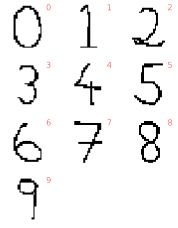

In [124]:
plot_digit_array(my_digits, labels, True)

In [130]:
y_test_hot = keras.utils.to_categorical(labels, num_classes)
x_test = my_digits.reshape(my_digits.shape[0], rows, cols, 1)

In [131]:
x_test.shape

(10, 28, 28, 1)

Now I will retrain the NN and use my digits as the validation set while keeping the same learning set as before.

In [134]:
# instantiate model
model = keras.Sequential(
[
    layers.Conv2D(input_shape=(rows,cols, 1), kernel_size=(5, 5), filters=7,
                  activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(4, 4)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# model = keras.Sequential(
# [
#     layers.Conv2D(input_shape=(rows,cols,1), kernel_size=(5, 5), filters=10,
#                   activation='relu', padding='same'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Conv2D(20, (5, 5), activation='relu'),
#     layers.Dropout(0.5),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Flatten(),
#     layers.Dense(20*4*4, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])


# compile 
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 7)         182       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 343)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                3440      
Total params: 3,622
Trainable params: 3,622
Non-trainable params: 0
_________________________________________________________________


In [135]:
batch_size = 32
epochs = 10

training = model.fit(x_train,y_train_hot, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test_hot))

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.7136 - accuracy: 0.7832 - val_loss: 2.7658 - val_accuracy: 0.6000
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1456 - accuracy: 0.9570 - val_loss: 2.9726 - val_accuracy: 0.5000
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1058 - accuracy: 0.9685 - val_loss: 3.0553 - val_accuracy: 0.5000
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0862 - accuracy: 0.9748 - val_loss: 3.2169 - val_accuracy: 0.5000
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0726 - accuracy: 0.9775 - val_loss: 3.6502 - val_accuracy: 0.5000
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0698 - accuracy: 0.9792 - val_loss: 4.2013 - val_accuracy: 0.5000
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0614 - accuracy: 0.9805 - val_loss: 4.0484 - val_ac

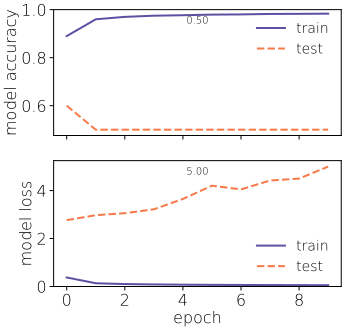

In [136]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, figsize=(5,5))

score = model.evaluate(x_test, y_test_hot, verbose=0);

# accuracy
ax[0].plot(training.history['accuracy'], color=colors[0])
ax[0].plot(training.history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].text(0.5,0.95,f'{score[1]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[0].transAxes)
ax[0].set_ylim(top=1)

# loss
ax[1].plot(training.history['loss'], color=colors[0])
ax[1].plot(training.history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylim(bottom=0)
ax[1].text(0.5,0.95,f'{score[0]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[1].transAxes)
ax[1].legend(['train', 'test'], loc='best');

In [137]:
predictions_prob_train = model(x_train)
predictions_prob_test = model(x_test)

predictions_train = np.argmax(predictions_prob_train,axis=1)
predictions_test = np.argmax(predictions_prob_test,axis=1)

mistakes_train = np.where(predictions_train != y_train)[0]
mistakes_test = np.where(predictions_test != labels)[0]

num_mistakes_train,num_mistakes_test = len(mistakes_train),len(mistakes_test)

print(f'Train Mistakes: {100*num_mistakes_train/x_train.shape[0]:.2f}%')
print(f'Test Mistakes : {100*num_mistakes_test/x_test.shape[0]:.2f}%')

Train Mistakes: 1.48%
Test Mistakes : 50.00%


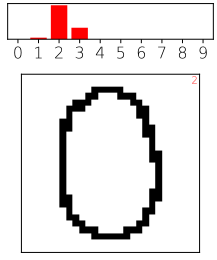

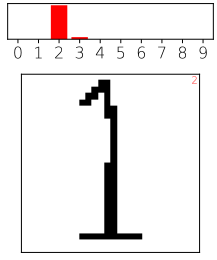

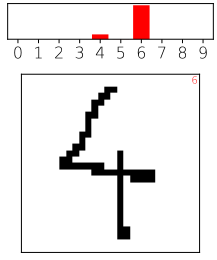

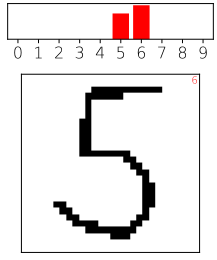

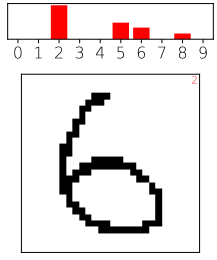

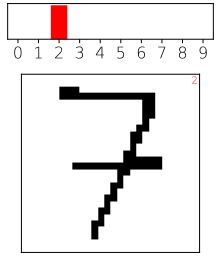

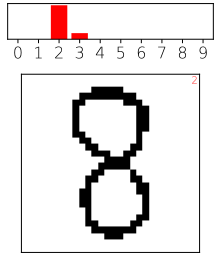

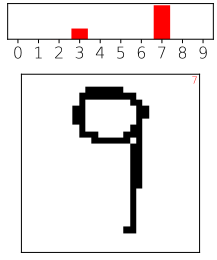

In [99]:
from matplotlib import gridspec

for idx in mistakes_test:

#     idx = np.random.choice(mistakes_test)

    fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

    ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

    ax[0].bar(range(num_classes),predictions_prob_test[idx], color='r')
    ax[0].set_xticks(range(num_classes))
    ax[0].set_yticks([]);
    ax[0].set_xlim(-0.5,9.5)

    ax[1].matshow(x_test[idx,:].reshape(rows,cols), cmap='binary')
    ax[1].text(0.99,0.99,f'{predictions_test[idx]}',horizontalalignment='right',verticalalignment='top', 
                             transform=ax[1].transAxes, color='r')
    ax[1].set_xticks([]);
    ax[1].set_yticks([]);

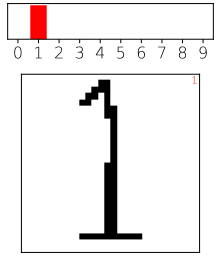

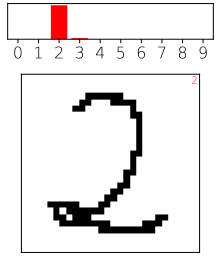

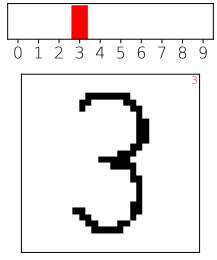

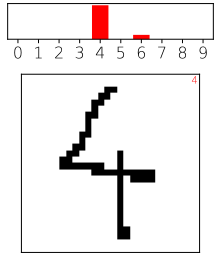

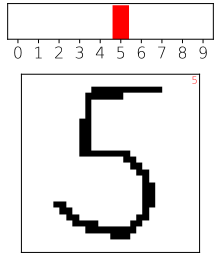

In [138]:
correct_test = np.where(predictions_test == labels)[0]

for idx in correct_test:

#     idx = np.random.choice(mistakes_test)

    fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

    ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

    ax[0].bar(range(num_classes),predictions_prob_test[idx], color='r')
    ax[0].set_xticks(range(num_classes))
    ax[0].set_yticks([]);
    ax[0].set_xlim(-0.5,9.5)

    ax[1].matshow(x_test[idx,:].reshape(rows,cols), cmap='binary')
    ax[1].text(0.99,0.99,f'{predictions_test[idx]}',horizontalalignment='right',verticalalignment='top', 
                             transform=ax[1].transAxes, color='r')
    ax[1].set_xticks([]);
    ax[1].set_yticks([]);

My dataset didn't do well; only two of the digits were recognized correctly. This could likely be due to the fact that I did not manage to process the dataset correctly, or that my test set looks very different from their training set.